**[SNE-01]** モジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [12]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

**[SNE-02]** トレーニングセットのデータを生成します。

In [2]:
def generate_datablock(n, mu, var, t):
    data = multivariate_normal(mu, np.eye(2)*var, n)
    df = DataFrame(data, columns=['x1','x2'])
    df['t'] = t
    return df

df0 = generate_datablock(15, [7,7], 22, 0)
df1 = generate_datablock(15, [22,7], 22, 0)
df2 = generate_datablock(10, [7,22], 22, 0)
df3 = generate_datablock(25, [20,20], 22, 1)

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

**[SNE-03]** (x1, x2) と t を別々に集めたものをNumPyのarrayオブジェクトとして取り出しておきます。

In [3]:
train_x = train_set[['x1','x2']].as_matrix()
train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])

**[SNE-04]** 単層ネットワークによる二項分類器のモデルを定義します。

In [6]:
num_units = 2
mult = train_x.flatten().mean()

x = tf.placeholder(tf.float32, [None, 2])

w1 = tf.Variable(tf.truncated_normal([2, num_units]))
b1 = tf.Variable(tf.zeros([num_units]))
hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)

w0 = tf.Variable(tf.zeros([num_units, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden1, w0) + b0*mult)

**[SNE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [7]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[SNE-06]** セッションを用意して、Variableを初期化します。

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**[SNE-07]** パラメーターの最適化を1000回繰り返します。

In [16]:
i = 0
for _ in range(1000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 100 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 100, Loss: 44.921848, Accuracy: 0.430769
Step: 200, Loss: 39.270321, Accuracy: 0.676923
Step: 300, Loss: 51.999809, Accuracy: 0.584615
Step: 400, Loss: 21.687222, Accuracy: 0.907692
Step: 500, Loss: 12.668480, Accuracy: 0.953846
Step: 600, Loss: 11.944666, Accuracy: 0.953846
Step: 700, Loss: 11.451056, Accuracy: 0.953846
Step: 800, Loss: 10.919858, Accuracy: 0.953846
Step: 900, Loss: 10.572514, Accuracy: 0.953846
Step: 1000, Loss: 10.580077, Accuracy: 0.953846


**[SNE-08]** 得られた確率を色の濃淡で図示します。

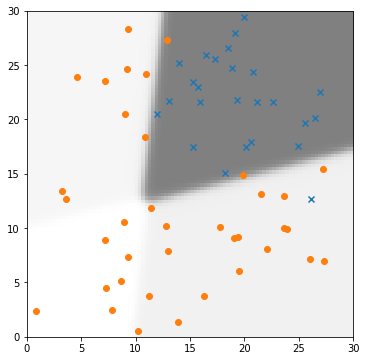

In [13]:
train_set1 = train_set[train_set['t']==1]
train_set2 = train_set[train_set['t']==0]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set2.x1, train_set2.x2, marker='o')

locations = []
for x2 in np.linspace(0,30,100):
    for x1 in np.linspace(0,30,100):
        locations.append((x1,x2))
p_vals = sess.run(p, feed_dict={x:locations})
p_vals = p_vals.reshape((100,100))
subplot.imshow(p_vals, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)